In [2]:
#  importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.sparse import csr_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import NMF, TruncatedSVD
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

In [3]:
#  lets load book Raw data
url = "https://raw.githubusercontent.com/zygmuntz/goodbooks-10k/master/ratings.csv"

# Load book metadata
meta_url = "https://raw.githubusercontent.com/zygmuntz/goodbooks-10k/master/books.csv"

ratings = pd.read_csv(url)
books = pd.read_csv(meta_url)

print(" Datasets loaded successfully")
print(f"Ratings dataset shape: {ratings.shape}")
print(f"Books dataset shape: {books.shape}")

 Datasets loaded successfully
Ratings dataset shape: (5976479, 3)
Books dataset shape: (10000, 23)


In [4]:
ratings.head()

,user_id,book_id,rating
0,1,258,5
1,2,4081,4
2,2,260,5
3,2,9296,5
4,2,2318,3


In [5]:
ratings.tail()

,user_id,book_id,rating
5976474,49925,510,5
5976475,49925,528,4
5976476,49925,722,4
5976477,49925,949,5
5976478,49925,1023,4


## Data preprocessing

In [6]:
# lets keep necessary columns and drop unnecessary
keep_cols = [
    'book_id',
    'title',
    'authors',
    'original_publication_year',
    'average_rating',
    'ratings_count'
]

books = books[keep_cols]

In [7]:
books.head()

,book_id,title,authors,original_publication_year,average_rating,ratings_count
0,1,"The Hunger Games (The Hunger Games, #1)",Suzanne Collins,2008.0,4.34,4780653
1,2,Harry Potter and the Sorcerer's Stone (Harry P...,"J.K. Rowling, Mary GrandPré",1997.0,4.44,4602479
2,3,"Twilight (Twilight, #1)",Stephenie Meyer,2005.0,3.57,3866839
3,4,To Kill a Mockingbird,Harper Lee,1960.0,4.25,3198671
4,5,The Great Gatsby,F. Scott Fitzgerald,1925.0,3.89,2683664


In [8]:
books.tail()

,book_id,title,authors,original_publication_year,average_rating,ratings_count
9995,9996,"Bayou Moon (The Edge, #2)",Ilona Andrews,2010.0,4.09,17204
9996,9997,"Means of Ascent (The Years of Lyndon Johnson, #2)",Robert A. Caro,1990.0,4.25,12582
9997,9998,The Mauritius Command,Patrick O'Brian,1977.0,4.35,9421
9998,9999,Cinderella Ate My Daughter: Dispatches from th...,Peggy Orenstein,2011.0,3.65,11279
9999,10000,The First World War,John Keegan,1998.0,4.00,9162


In [9]:
books.describe()

,book_id,original_publication_year,average_rating,ratings_count
count,10000.00000,9979.000000,10000.000000,1.000000e+04
mean,5000.50000,1981.987674,4.002191,5.400124e+04
std,2886.89568,152.576665,0.254427,1.573700e+05
min,1.00000,-1750.000000,2.470000,2.716000e+03
25%,2500.75000,1990.000000,3.850000,1.356875e+04
50%,5000.50000,2004.000000,4.020000,2.115550e+04
75%,7500.25000,2011.000000,4.180000,4.105350e+04
max,10000.00000,2017.000000,4.820000,4.780653e+06


In [10]:
# lets check for missing values
print("Ratings dataset missing values")
print(ratings.isnull().sum())

Ratings dataset missing values
user_id    0
book_id    0
rating     0
dtype: int64


In [11]:
print("Books dataset missing values")
print(books.isnull().sum())

Books dataset missing values
book_id                       0
title                         0
authors                       0
original_publication_year    21
average_rating                0
ratings_count                 0
dtype: int64


In [12]:
# lets drop rows with nan values
books.dropna(subset=['original_publication_year'], inplace=True)

# Confirm drop
print("Missing values after:", books['original_publication_year'].isna().sum())
print("Remaining rows:", len(books))

Missing values after: 0
Remaining rows: 9979


In [13]:
books.isnull().sum()

book_id                      0
title                        0
authors                      0
original_publication_year    0
average_rating               0
ratings_count                0
dtype: int64

In [14]:
# Lets check duplicates
books.duplicated().sum()

np.int64(0)

In [15]:
ratings.duplicated().sum()

np.int64(0)

In [16]:
# Lets check overlap between book id's
common_books = set(ratings['book_id']).intersection(set(books['book_id']))
print(f"\nCommon Book IDs between datasets: {len(common_books)}")


Common Book IDs between datasets: 9979


In [17]:
# filtering
ratings = ratings[ratings['book_id'].isin(common_books)]
print(f"Ratings shape after alignment: {ratings.shape}")

Ratings shape after alignment: (5970537, 3)


In [18]:
# lets check for outliers in ratings
sorted(ratings['rating'].unique())
print(f"Unique ratings: {sorted(ratings['rating'].unique())}")

Unique ratings: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5)]


In [19]:
# Basic filtering to reduce sparsity
min_user_ratings = 10
min_book_ratings = 10

active_users  = ratings['user_id'].value_counts()
active_user_ids = active_users[active_users >= min_user_ratings].index
ratings = ratings[ratings['user_id'].isin(active_user_ids)]

popular_books = ratings['book_id'].value_counts()
popular_book_ids = popular_books[popular_books >= min_book_ratings].index
ratings = ratings[ratings['book_id'].isin(popular_book_ids)]


print(f"Ratings shape after filtering: {ratings.shape}")

Ratings shape after filtering: (5970529, 3)


In [20]:
num_users = ratings['user_id'].nunique()
num_books = ratings['book_id'].nunique()
num_ratings = len(ratings)

sparsity = 1 - (num_ratings / (num_users * num_books))
print(f"Number of users: {num_users}")
print(f"Number of books: {num_books}")
print(f"Number of ratings: {num_ratings}")
print(f"Sparsity: {sparsity:.4f}")

Number of users: 53424
Number of books: 9978
Number of ratings: 5970529
Sparsity: 0.9888


## Exploratory data analysis

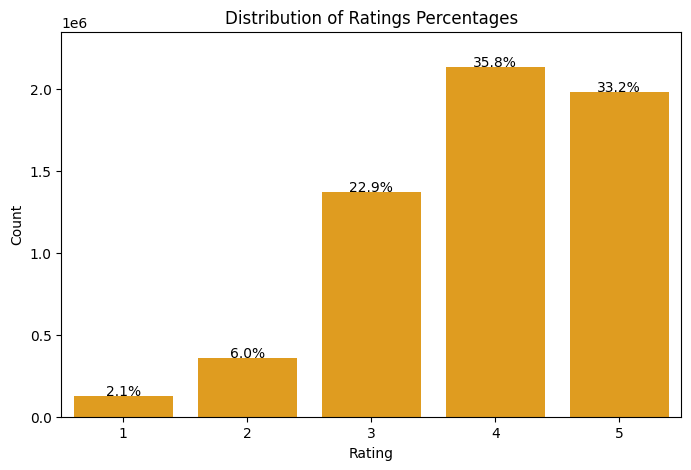

In [21]:
# lets visualize ratings of book
ratings_count = ratings['rating'].value_counts().sort_index()
rating_percent = ratings_count / ratings_count.sum()*100

plt.figure(figsize=(8,5))
sns.barplot(x=ratings_count.index, y=ratings_count.values, color='orange')

for i, count in enumerate(ratings_count.values):
    plt.text(i, count + 5000, f"{rating_percent.values[i]:.1f}%", ha='center', fontsize=10)

plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Distribution of Ratings Percentages')
plt.ylim(0, ratings_count.max() * 1.1)
plt.show()

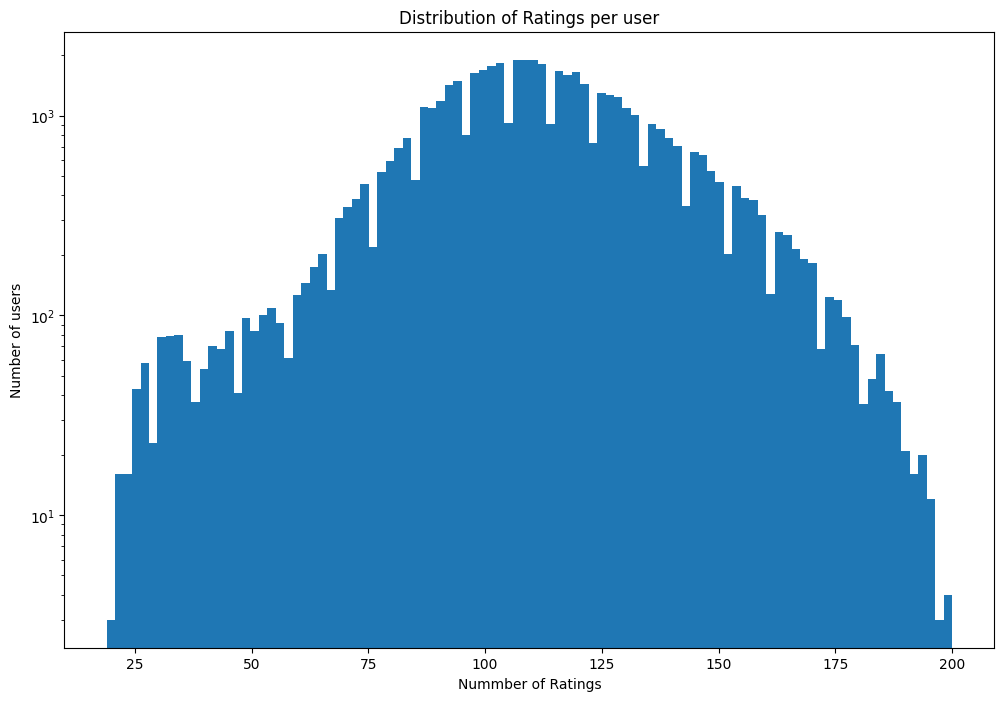

In [22]:
# Ratings per user
user_ratings_count = ratings['user_id'].value_counts()
plt.figure(figsize=(12,8))
plt.hist(user_ratings_count, bins=100, log = True)
plt.xlabel('Nummber of Ratings')
plt.ylabel('Number of users')
plt.title('Distribution of Ratings per user')
plt.show()


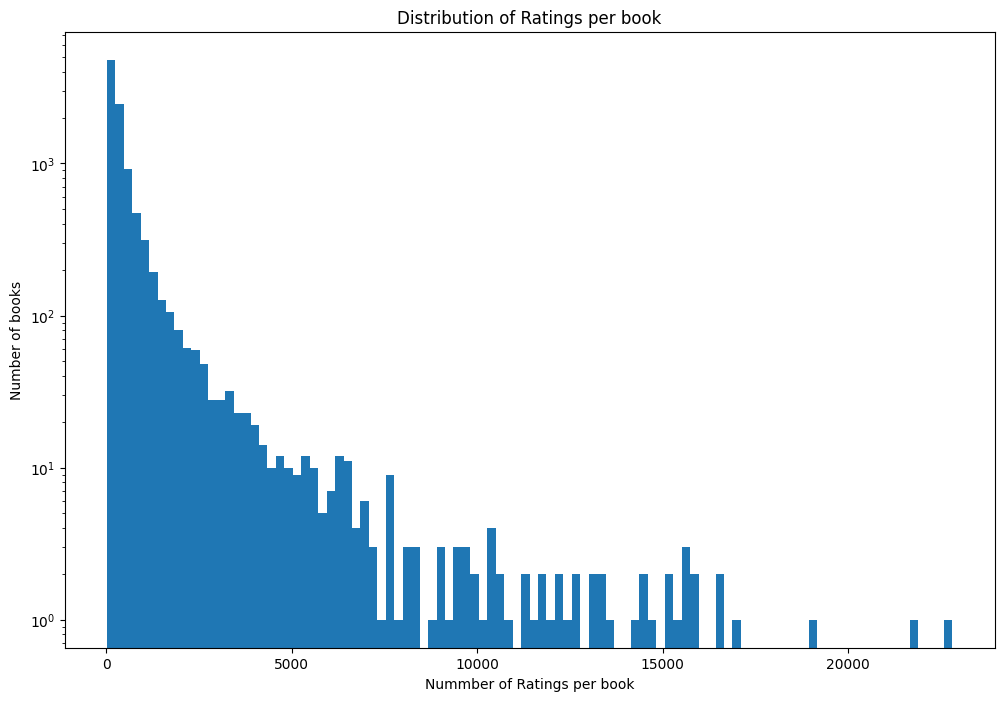

In [23]:
# Ratings per book
book_counts = ratings['book_id'].value_counts()
plt.figure(figsize=(12,8))
plt.hist(book_counts, bins=100, log = True)
plt.xlabel('Nummber of Ratings per book')
plt.ylabel('Number of books')
plt.title('Distribution of Ratings per book')
plt.show()

In [24]:
# lets visualize Most popular books
top_n = 30
top_books = book_counts.head(top_n).reset_index()
top_books.columns = ['book_id','ratings_count']
top_books = top_books.merge(books[['book_id', 'title', 'authors']], on='book_id', how = 'left')
display(top_books)

,book_id,ratings_count,title,authors
0,1,22806,"The Hunger Games (The Hunger Games, #1)",Suzanne Collins
1,2,21850,Harry Potter and the Sorcerer's Stone (Harry P...,"J.K. Rowling, Mary GrandPré"
2,4,19088,To Kill a Mockingbird,Harper Lee
3,3,16931,"Twilight (Twilight, #1)",Stephenie Meyer
4,5,16604,The Great Gatsby,F. Scott Fitzgerald
5,17,16549,"Catching Fire (The Hunger Games, #2)",Suzanne Collins
6,20,15953,"Mockingjay (The Hunger Games, #3)",Suzanne Collins
7,18,15855,Harry Potter and the Prisoner of Azkaban (Harr...,"J.K. Rowling, Mary GrandPré, Rufus Beck"
8,23,15657,Harry Potter and the Chamber of Secrets (Harry...,"J.K. Rowling, Mary GrandPré"
9,7,15558,The Hobbit,J.R.R. Tolkien


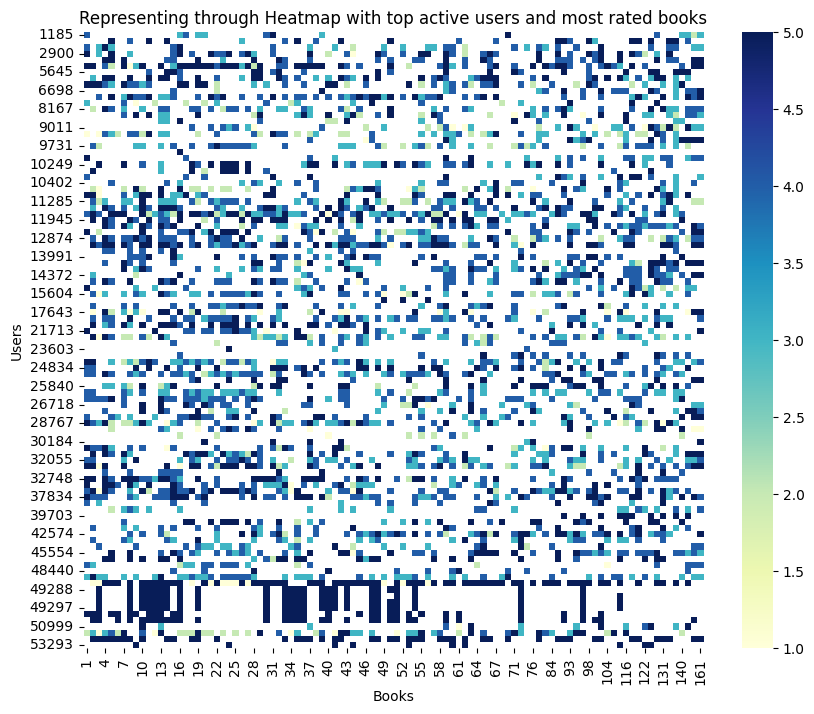

In [25]:
# lets visualize the most active users and most rated books
top_users = user_ratings_count.head(100).index
top_books = book_counts.head(100).index
top_ratings = ratings[(ratings['user_id'].isin(top_users)) & (ratings['book_id'].isin(top_books))]

pivot = top_ratings.pivot_table(index = 'user_id', columns = 'book_id', values = 'rating')
plt.figure(figsize=(10,8))
sns.heatmap(pivot, cmap='YlGnBu')
plt.xlabel('Books')
plt.ylabel('Users')
plt.title('Representing through Heatmap with top active users and most rated books')
plt.show()

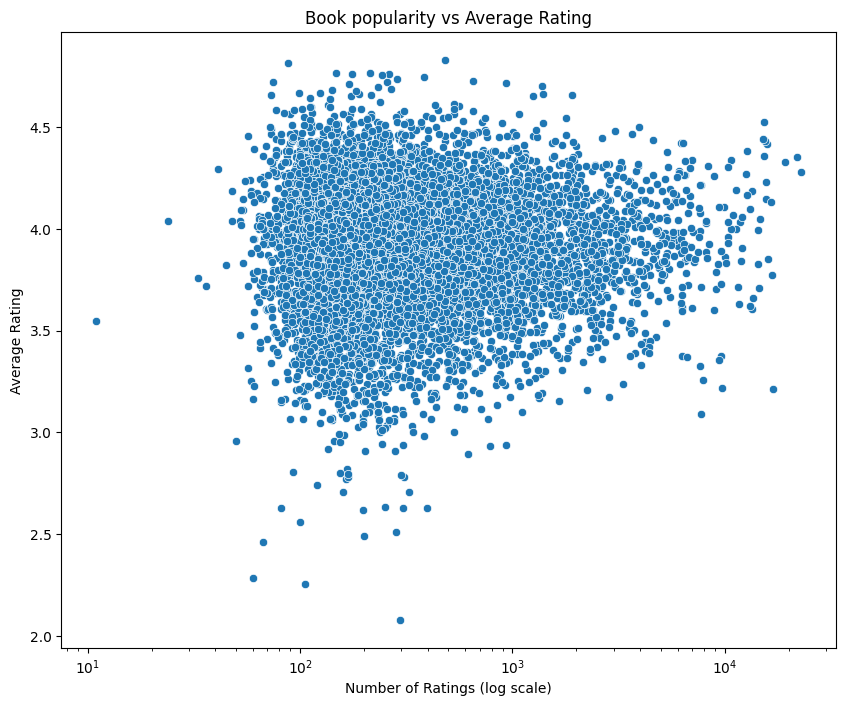

In [26]:
# lets check Co-relation between rating and book
book_avg_rating = ratings.groupby('book_id')['rating'].mean()
book_rating_count = ratings['book_id'].value_counts()

plt.figure(figsize=(10,8))
sns.scatterplot(x = book_rating_count, y = book_avg_rating)
plt.xlabel('Number of Ratings (log scale)')
plt.ylabel('Average Rating')
plt.title('Book popularity vs Average Rating')
plt.xscale('log')
plt.show()

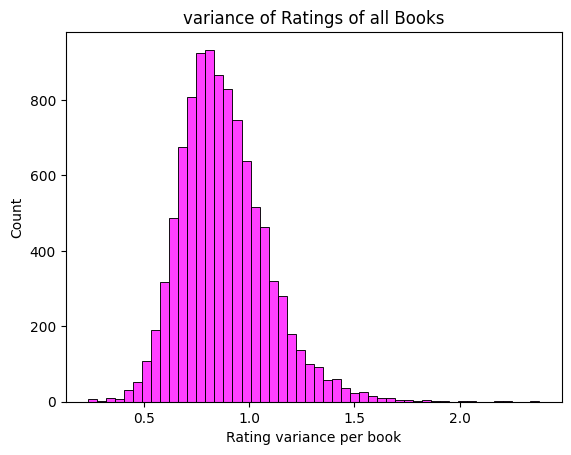

In [27]:
# lets calculate the rating variance for books
book_variance = ratings.groupby('book_id')['rating'].var().dropna()
sns.histplot(book_variance, bins=50, color = 'magenta')
plt.title('variance of Ratings of all Books')
plt.xlabel('Rating variance per book')
plt.show()

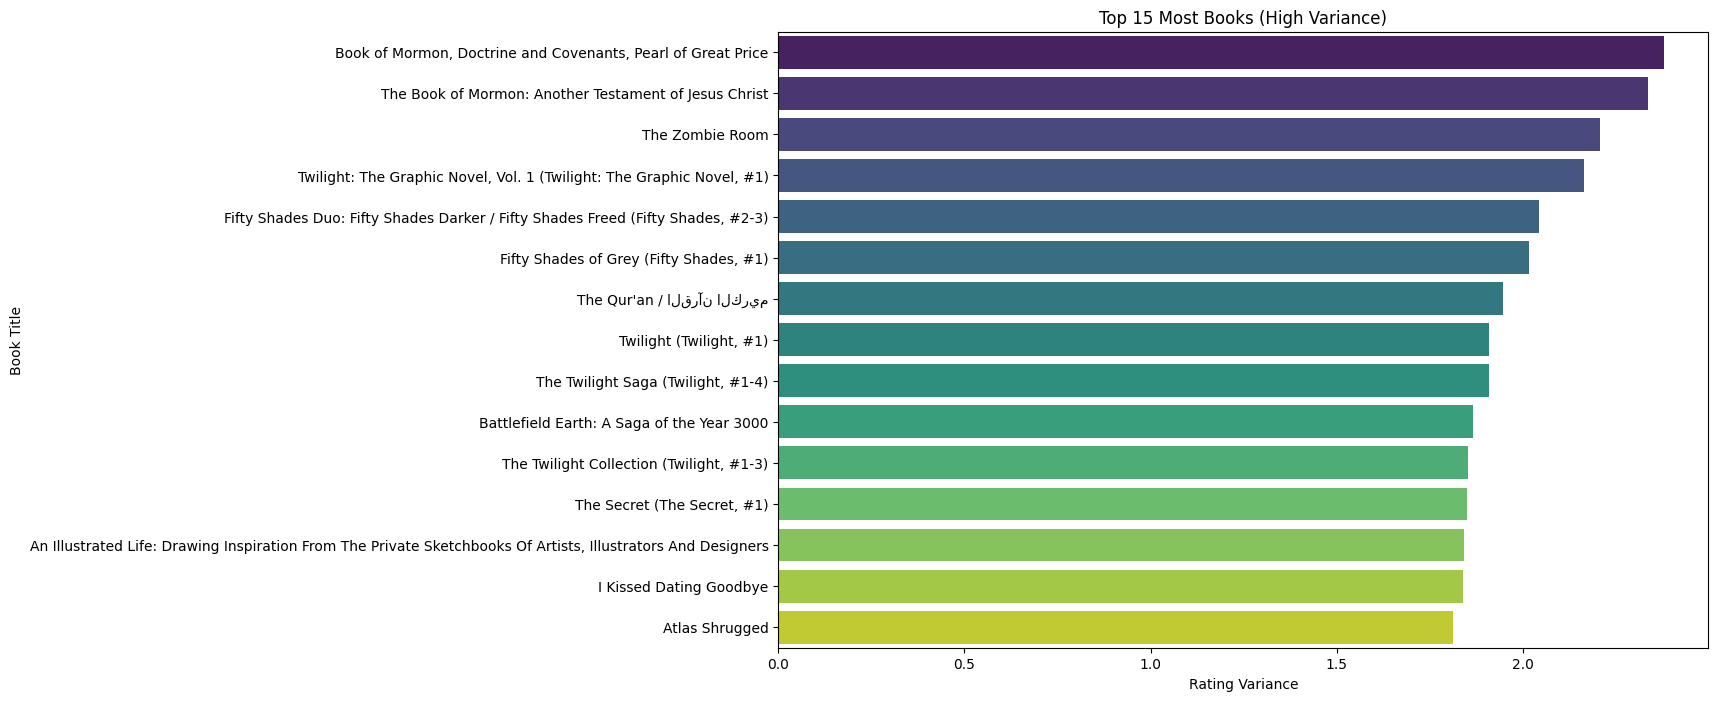

In [28]:
# lets check the books which has high variance
top = book_variance.sort_values(ascending = False).head(15)
books_info = pd.merge(top.reset_index(), books[['book_id', 'title', 'authors']], on = 'book_id')
books_info.rename(columns={'ratings': 'rating variance'}, inplace = True)

plt.figure(figsize=(12,8))
sns.barplot(data=books_info.head(15), x='rating', y='title', palette='viridis')
plt.xlabel('Rating Variance')
plt.ylabel('Book Title')
plt.title('Top 15 Most Books (High Variance)')
plt.show()

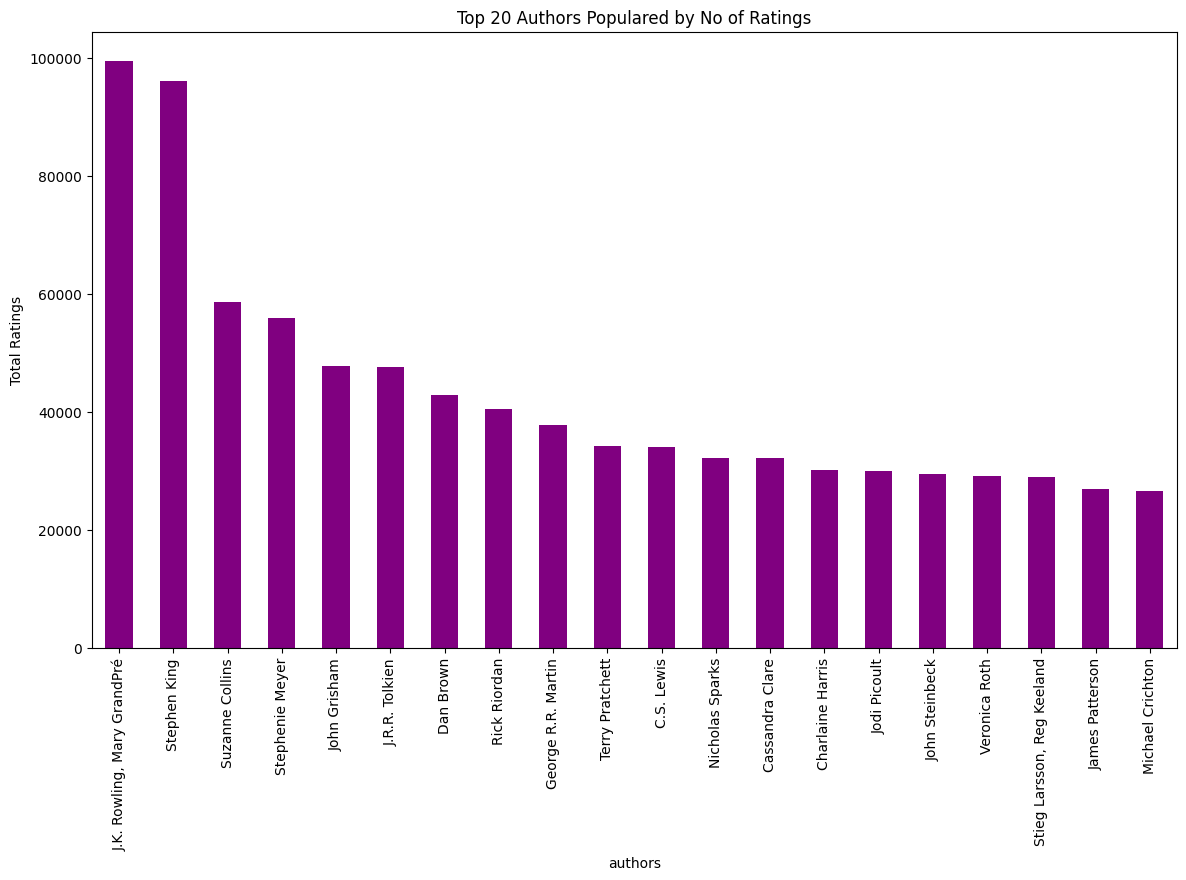

In [29]:
# top authors populared by ratings
top_authors = books.merge(ratings, on='book_id').groupby('authors')['rating'].count().sort_values(ascending=False).head(20)
top_authors.plot(kind='bar', figsize=(14,8), color = 'purple')

plt.title('Top 20 Authors Populared by No of Ratings')
plt.ylabel('Total Ratings')
plt.show()

In [30]:
# lets compute final sparsity
num_users = ratings['user_id'].nunique()
num_books = ratings['book_id'].nunique()
num_ratings = len(ratings)
sparsity = 1 - (num_ratings / (num_users * num_books))
print(f"Sparsity: {sparsity:.4f} ({(1-sparsity)*100:.3f}% density)")

Sparsity: 0.9888 (1.120% density)


step 1: we will move on with memory based collaborative filtering ( user and item based )

step 2: model based CF - train matrix factorisation models (SVD,NMF)

## user based Collaborative filtering

In [1]:
from surprise import Dataset, Reader, KNNBasic, accuracy
from surprise.model_selection import train_test_split
from collections import defaultdict

In [2]:
import pandas as pd
url = "https://raw.githubusercontent.com/zygmuntz/goodbooks-10k/master/ratings.csv"

ratings = pd.read_csv(
    url,
    usecols=["user_id", "book_id", "rating"],
    dtype={"user_id": "int32", "book_id": "int32", "rating": "float32"},
    nrows=500000,  
)
print(" Ratings loaded:", ratings.shape)

# surprise dataset
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings[["user_id", "book_id", "rating"]], reader)
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

# user based cf model
sim_options = {"name": "cosine", "user_based": True}
algo = KNNBasic(sim_options=sim_options, verbose=False)
algo.fit(trainset)

# test set
predictions = algo.test(testset)

# Evaluation
rmse = accuracy.rmse(predictions, verbose=True)
mae = accuracy.mae(predictions, verbose=True)

 Ratings loaded: (500000, 3)
RMSE: 0.9670
MAE:  0.7742


In [3]:
from collections import defaultdict
import numpy as np

def precision_at_k(predictions, k=10, threshold=3.5):
    """Compute overall Precision@K."""
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = []
    for uid, user_ratings in user_est_true.items():
        user_ratings.sort(key=lambda x: x[0], reverse=True)
        top_k = user_ratings[:k]

        n_rel_and_rec_k = sum((true_r >= threshold) and (est >= threshold) for est, true_r in top_k)
        n_rec_k = sum(est >= threshold for est, _ in top_k)

        precision = n_rel_and_rec_k / n_rec_k if n_rec_k else 0
        precisions.append(precision)

    return np.mean(precisions)

precision_k = precision_at_k(predictions, k=10, threshold=3.5)
print(f"\n Precision@10: {precision_k:.4f}")



 Precision@10: 0.7019


In [4]:
def get_top_n(predictions, n=5):
    """Return the top-N recommendation list for each user."""
    from collections import defaultdict

    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Sort the predictions 
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]
    return top_n

# predictions from testset
top_n = get_top_n(predictions, n=5)

example_user_id = ratings['user_id'].iloc[0]

if example_user_id in top_n:
    print(f"\n Top 5 Recommended Books for User {example_user_id}:")
    for book_id, est_rating in top_n[example_user_id]:
        print(f"Book ID {book_id} | Predicted Rating: {est_rating:.2f}")
else:
    print(f"User {example_user_id} not found in predictions.")


 Top 5 Recommended Books for User 1:
Book ID 4 | Predicted Rating: 4.17
Book ID 11 | Predicted Rating: 4.12
Book ID 13 | Predicted Rating: 4.12
Book ID 43 | Predicted Rating: 3.85
Book ID 1796 | Predicted Rating: 3.75


In [5]:
meta_url = "https://raw.githubusercontent.com/zygmuntz/goodbooks-10k/master/books.csv"

books = pd.read_csv(
    meta_url,
    usecols=["book_id", "title", "authors"],
    dtype={"book_id": "int32", "title": "string", "authors": "string"},
)

example_user_id = 1  

if example_user_id in top_n:
    user_recs = pd.DataFrame(top_n[example_user_id], columns=["book_id", "predicted_rating"])
    # Merge with metadata
    user_recs = user_recs.merge(books, on="book_id", how="left")
    
    print(f"\n Top 5 Recommended Books for User {example_user_id}:\n")
    for _, row in user_recs.iterrows():
        print(f"Title  : {row['title']}")
        print(f"Author : {row['authors']}")
        print(f"Predicted Rating: {row['predicted_rating']:.2f}")
        print("-" * 50)
else:
    print(f"User {example_user_id} not found in predictions.")


 Top 5 Recommended Books for User 1:

Title  : To Kill a Mockingbird
Author : Harper Lee
Predicted Rating: 4.17
--------------------------------------------------
Title  : The Kite Runner
Author : Khaled Hosseini
Predicted Rating: 4.12
--------------------------------------------------
Title  : 1984
Author : George Orwell, Erich Fromm, Celâl Üster
Predicted Rating: 4.12
--------------------------------------------------
Title  : Jane Eyre
Author : Charlotte Brontë, Michael Mason
Predicted Rating: 3.85
--------------------------------------------------
Title  : Gilead (Gilead, #1)
Author : Marilynne Robinson
Predicted Rating: 3.75
--------------------------------------------------


## Item Based collaborative filtering

In [6]:
url = "https://raw.githubusercontent.com/zygmuntz/goodbooks-10k/master/ratings.csv"
ratings = pd.read_csv(
    url,
    usecols=["user_id", "book_id", "rating"],
    dtype={"user_id": "int32", "book_id": "int32", "rating": "float32"},
    nrows=500000,  
)
print(" Ratings loaded:", ratings.shape)

# surprise dataset
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings[["user_id", "book_id", "rating"]], reader)
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)


# Item-Based KNN model
sim_options = {"name": "cosine", "user_based": False}  
algo_item = KNNBasic(sim_options=sim_options, verbose=False)
algo_item.fit(trainset)

# pred
predictions_item = algo_item.test(testset)

# evaluation
rmse_item = accuracy.rmse(predictions_item, verbose=True)
mae_item = accuracy.mae(predictions_item, verbose=True)


 Ratings loaded: (500000, 3)
RMSE: 0.9282
MAE:  0.7324


In [7]:
def precision_at_k(predictions, k=10, threshold=3.5):
    user_est_true = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        user_est_true[str(uid)].append((est, true_r))  

    precisions = []
    for uid, user_ratings in user_est_true.items():
        user_ratings.sort(key=lambda x: x[0], reverse=True)
        top_k = user_ratings[:k]

        n_rel_and_rec_k = sum((true_r >= threshold) and (est >= threshold) for est, true_r in top_k)
        n_rec_k = sum(est >= threshold for est, _ in top_k)
        precision = n_rel_and_rec_k / n_rec_k if n_rec_k else 0
        precisions.append(precision)

    return np.mean(precisions)

precision_item_k = precision_at_k(predictions_item, k=10, threshold=3.5)
print(f"Precision@10 : {precision_item_k:.4f}")

Precision@10 : 0.6334


In [8]:
def get_top_n_from_predictions(predictions, n=5):
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[str(uid)].append((iid, est))
    # keep top n
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]
    return top_n

# create top_n_item 
top_n_item = get_top_n_from_predictions(predictions_item, n=5)

# Load book metadata 
meta_url = "https://raw.githubusercontent.com/zygmuntz/goodbooks-10k/master/books.csv"
books = pd.read_csv(
    meta_url,
    usecols=["book_id", "title", "authors"],
    dtype={"book_id": "int32", "title": "string", "authors": "string"},
)

example_user_id = 43

# print Top-5 books for this user
if str(example_user_id) in top_n_item:
    user_recs = pd.DataFrame(top_n_item[str(example_user_id)], columns=["book_id", "predicted_rating"])
    user_recs = user_recs.merge(books, on="book_id", how="left")

    print(f"\n Top 5 Recommended Books for User {example_user_id}:\n")
    for _, row in user_recs.iterrows():
        print(f"Title  : {row['title']}")
        print(f"Author : {row['authors']}")
        print(f"Predicted Rating: {row['predicted_rating']:.2f}")
        print("-" * 50)
else:
    print(f"No top-n predictions available for user {example_user_id}.")


 Top 5 Recommended Books for User 43:

Title  : Native Tongue (Skink, #2)
Author : Carl Hiaasen
Predicted Rating: 4.06
--------------------------------------------------
Title  : Raise High the Roof Beam, Carpenters & Seymour: An Introduction
Author : J.D. Salinger
Predicted Rating: 4.00
--------------------------------------------------
Title  : Much Ado About Nothing
Author : William Shakespeare, Barbara A. Mowat, Paul Werstine, Gail Kern Paster, Robert          Jackson
Predicted Rating: 3.92
--------------------------------------------------
Title  : Prep
Author : Curtis Sittenfeld
Predicted Rating: 3.92
--------------------------------------------------
Title  : The River Why
Author : David James Duncan
Predicted Rating: 3.91
--------------------------------------------------


## step : 2 Model based collaborative filtering

## singular value decompisition-(svd)

In [9]:
from surprise import SVD
url = "https://raw.githubusercontent.com/zygmuntz/goodbooks-10k/master/ratings.csv"
ratings = pd.read_csv(
    url,
    usecols=["user_id", "book_id", "rating"],
    dtype={"user_id": "int32", "book_id": "int32", "rating": "float32"},
    nrows=500000
)
print(" Ratings loaded:", ratings.shape)

#surprise dataset
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings[["user_id", "book_id", "rating"]], reader)
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

# Train SVD model
algo_svd = SVD(random_state=42)
algo_svd.fit(trainset)

# Evaluvate
predictions_svd = algo_svd.test(testset)

rmse_svd = accuracy.rmse(predictions_svd, verbose=True)
mae_svd = accuracy.mae(predictions_svd, verbose=True)

def precision_at_k(predictions, k=10, threshold=3.5):
    """Compute overall Precision@K."""
    user_est_true = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        user_est_true[str(uid)].append((est, true_r))

    precisions = []
    for uid, user_ratings in user_est_true.items():
        user_ratings.sort(key=lambda x: x[0], reverse=True)
        top_k = user_ratings[:k]
        n_rel_and_rec_k = sum((true_r >= threshold) and (est >= threshold) for est, true_r in top_k)
        n_rec_k = sum(est >= threshold for est, _ in top_k)
        precision = n_rel_and_rec_k / n_rec_k if n_rec_k else 0
        precisions.append(precision)

    return np.mean(precisions)

precision_svd_k = precision_at_k(predictions_svd, k=10, threshold=3.5)
print(f"Precision@10 : {precision_svd_k:.4f}")


 Ratings loaded: (500000, 3)
RMSE: 0.8816
MAE:  0.6925
Precision@10 : 0.7178


In [10]:
def get_top_n_from_predictions(predictions, n=5):
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[str(uid)].append((iid, est))
    for uid, items in top_n.items():
        items.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = items[:n]
    return top_n

top_n_svd = get_top_n_from_predictions(predictions_svd, n=5)

meta_url = "https://raw.githubusercontent.com/zygmuntz/goodbooks-10k/master/books.csv"
books = pd.read_csv(
    meta_url,
    usecols=["book_id", "title", "authors"],
    dtype={"book_id": "int32", "title": "string", "authors": "string"}
)

example_user_id = 1

if str(example_user_id) in top_n_svd:
    user_recs = pd.DataFrame(top_n_svd[str(example_user_id)], columns=["book_id", "predicted_rating"])
    user_recs = user_recs.merge(books, on="book_id", how="left")

    print(f"\n Top 5 SVD-Based Recommendations for User {example_user_id}:\n")
    for _, row in user_recs.iterrows():
        print(f"Title  : {row['title']}")
        print(f"Author : {row['authors']}")
        print(f"Predicted Rating: {row['predicted_rating']:.2f}")
        print("-" * 50)
else:
    print(f"No top-n predictions available for user {example_user_id}.")


 Top 5 SVD-Based Recommendations for User 1:

Title  : To Kill a Mockingbird
Author : Harper Lee
Predicted Rating: 4.37
--------------------------------------------------
Title  : The Kite Runner
Author : Khaled Hosseini
Predicted Rating: 3.76
--------------------------------------------------
Title  : 1984
Author : George Orwell, Erich Fromm, Celâl Üster
Predicted Rating: 3.71
--------------------------------------------------
Title  : Jane Eyre
Author : Charlotte Brontë, Michael Mason
Predicted Rating: 3.68
--------------------------------------------------
Title  : Gilead (Gilead, #1)
Author : Marilynne Robinson
Predicted Rating: 3.35
--------------------------------------------------


## NoN NEGATIVE MATRIX FACTORIZATION

In [11]:
from surprise import NMF
url = "https://raw.githubusercontent.com/zygmuntz/goodbooks-10k/master/ratings.csv"
ratings = pd.read_csv(
    url,
    usecols=["user_id", "book_id", "rating"],
    dtype={"user_id": "int32", "book_id": "int32", "rating": "float32"},
    nrows=500000
)
print(" Ratings loaded:", ratings.shape)

#  Prepare dataset for Surprise
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings[["user_id", "book_id", "rating"]], reader)
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

#  Train NMF model
algo_nmf = NMF(n_factors=50, random_state=42)
algo_nmf.fit(trainset)


# evaluate
predictions_nmf = algo_nmf.test(testset)

rmse_nmf = accuracy.rmse(predictions_nmf, verbose=True)
mae_nmf = accuracy.mae(predictions_nmf, verbose=True)


#  Precision@K
def precision_at_k(predictions, k=10, threshold=3.5):
    """Compute overall Precision@K."""
    user_est_true = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        user_est_true[str(uid)].append((est, true_r))

    precisions = []
    for uid, user_ratings in user_est_true.items():
        user_ratings.sort(key=lambda x: x[0], reverse=True)
        top_k = user_ratings[:k]
        n_rel_and_rec_k = sum((true_r >= threshold) and (est >= threshold) for est, true_r in top_k)
        n_rec_k = sum(est >= threshold for est, _ in top_k)
        precision = n_rel_and_rec_k / n_rec_k if n_rec_k else 0
        precisions.append(precision)

    return np.mean(precisions)

precision_nmf_k = precision_at_k(predictions_nmf, k=10, threshold=3.5)
print(f"Precision@10 : {precision_nmf_k:.4f}")


 Ratings loaded: (500000, 3)
RMSE: 1.0205
MAE:  0.7657
Precision@10 : 0.6998


In [12]:
def get_top_n_from_predictions(predictions, n=5):
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[str(uid)].append((iid, est))
    for uid, items in top_n.items():
        items.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = items[:n]
    return top_n

top_n_nmf = get_top_n_from_predictions(predictions_nmf, n=5)

meta_url = "https://raw.githubusercontent.com/zygmuntz/goodbooks-10k/master/books.csv"
books = pd.read_csv(
    meta_url,
    usecols=["book_id", "title", "authors"],
    dtype={"book_id": "int32", "title": "string", "authors": "string"}
)

example_user_id = 1

if str(example_user_id) in top_n_nmf:
    user_recs = pd.DataFrame(top_n_nmf[str(example_user_id)], columns=["book_id", "predicted_rating"])
    user_recs = user_recs.merge(books, on="book_id", how="left")

    print(f"\nTop 5 NMF-Based Recommendations for User {example_user_id}:\n")
    for _, row in user_recs.iterrows():
        print(f"Title  : {row['title']}")
        print(f"Author : {row['authors']}")
        print(f"Predicted Rating: {row['predicted_rating']:.2f}")
        print("-" * 50)
else:
    print(f"No top-n predictions available for user {example_user_id}.")


Top 5 NMF-Based Recommendations for User 1:

Title  : To Kill a Mockingbird
Author : Harper Lee
Predicted Rating: 4.38
--------------------------------------------------
Title  : Jane Eyre
Author : Charlotte Brontë, Michael Mason
Predicted Rating: 4.35
--------------------------------------------------
Title  : The Kite Runner
Author : Khaled Hosseini
Predicted Rating: 4.32
--------------------------------------------------
Title  : 1984
Author : George Orwell, Erich Fromm, Celâl Üster
Predicted Rating: 4.06
--------------------------------------------------
Title  : Gilead (Gilead, #1)
Author : Marilynne Robinson
Predicted Rating: 3.40
--------------------------------------------------


In [ ]:
#Model	                   RMSE      MAE 	Precision@10 

User-Based CF	          0.9670	0.7742	0.7019	
Item-Based CF	          0.9282	0.7324	0.6334	
SVD (Matrix Factorization)0.8816  	0.6925 	0.7178 	Best overall — accurate & relevant
NMF (Non-Negative MF)	 1.0205  	0.7657	0.6998	

## save the best model

In [13]:
url = "https://raw.githubusercontent.com/zygmuntz/goodbooks-10k/master/ratings.csv"
ratings = pd.read_csv(url, usecols=["user_id", "book_id", "rating"]).sample(200000, random_state=42)

reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings[["user_id", "book_id", "rating"]], reader)

trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

#  Train SVD
svd = SVD(random_state=42)
svd.fit(trainset)

# Step 6 — Evaluate
predictions = svd.test(testset)
print("RMSE:")
accuracy.rmse(predictions)
print("MAE:")
accuracy.mae(predictions)


RMSE:
RMSE: 0.9441
MAE:
MAE:  0.7556


0.7555711662783171

In [14]:
# Save 
from surprise import dump
dump.dump('svd_best_model', algo=svd)
_, loaded_svd = dump.load('svd_best_model')
print(" Model loaded successfully")


 Model loaded successfully


## Content based collaborative filtering

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

meta_url = "https://raw.githubusercontent.com/zygmuntz/goodbooks-10k/master/books.csv"
books = pd.read_csv(meta_url, usecols=[
    "book_id", "title", "authors", "original_title", "language_code"
], dtype={
    "book_id": "int32", "title": "string", "authors": "string",
    "original_title": "string", "language_code": "string"
})

# Fill missing 
text_cols = ["title", "authors", "original_title", "language_code"]
for c in text_cols:
    books[c] = books[c].fillna("").astype("string")

# Combine into one text field
books["combined"] = (
    books["title"] + " " +
    books["authors"] + " " +
    books["original_title"] + " " +
    books["language_code"]
).str.lower().str.replace(r"\s+", " ", regex=True).str.strip()

# TF-IDF matrix
vectorizer = TfidfVectorizer(stop_words="english",
                             max_features=50_000,
                             ngram_range=(1,2),
                             min_df=2)
tfidf_matrix = vectorizer.fit_transform(books["combined"])

# Create mappings between book_id and index
bookid_to_idx = pd.Series(books.index.values, index=books["book_id"].values).to_dict()
idx_to_bookid = pd.Series(books["book_id"].values, index=books.index).to_dict()

print("TF-IDF matrix shape:", tfidf_matrix.shape)
print("Mapping created.")

TF-IDF matrix shape: (10000, 13056)
Mapping created.


In [16]:
# Create a mapping 
book_id_map = pd.Series(books.index, index=books["title"].str.lower()).to_dict()

from sklearn.metrics.pairwise import linear_kernel

def recommend_books(title, top_n=5):
    """
    Recommend top_n similar books based on a given title using TF-IDF cosine similarity.
    """
    title = title.lower().strip()
    if title not in book_id_map:
        matches = [t for t in book_id_map.keys() if title in t]
        if not matches:
            raise ValueError(f"No matches found for title '{title}'. Try a more complete title.")
        print(f"Closest match found: '{matches[0]}'")
        title = matches[0]
    
    idx = book_id_map[title]
    
    # Compute 
    cosine_sim = linear_kernel(tfidf_matrix[idx], tfidf_matrix).flatten()
    cosine_sim[idx] = -1.0
    
    # Get top N
    top_idx = np.argpartition(-cosine_sim, range(top_n))[:top_n]
    top_idx_sorted = top_idx[np.argsort(-cosine_sim[top_idx])]
    
    recommendations = books.loc[top_idx_sorted, ["book_id", "title", "authors"]].copy()
    recommendations["similarity_score"] = cosine_sim[top_idx_sorted].round(3)
    
    return recommendations.reset_index(drop=True)

In [ ]:
recommend_books("The Hobbit", top_n=5)

,book_id,title,authors,similarity_score
0,1129,"The History of the Hobbit, Part One: Mr. Baggins","John D. Rateliff, J.R.R. Tolkien",0.635
1,466,The Hobbit: Graphic Novel,"Chuck Dixon, J.R.R. Tolkien, David Wenzel, Sea...",0.602
2,964,J.R.R. Tolkien 4-Book Boxed Set: The Hobbit an...,J.R.R. Tolkien,0.588
3,2309,The Children of Húrin,"J.R.R. Tolkien, Christopher Tolkien, Alan Lee",0.204
4,611,The Silmarillion (Middle-Earth Universe),"J.R.R. Tolkien, Christopher Tolkien, Ted Nasmith",0.198


## Hybrid recommendation system (svd(cf)) + content based collaborative filtering

In [17]:
svd_top_books = [
    "The Missing Piece Meets the Big O",
    "Cat's Cradle",
    "Nine Stories",
    "Zorba the Greek",
    "The Complete Fairy Tales"
]
hybrid_recs = []

#  find top 3 TF-IDF similar books
for title in svd_top_books:
    try:
        recs = recommend_books(title, top_n=3)
        recs["source_book"] = title  
        hybrid_recs.append(recs)
    except Exception as e:
        print(f" Could not find '{title}' in TF-IDF data: {e}")

# Combine all TF-IDF expansions
hybrid_recs_df = pd.concat(hybrid_recs, ignore_index=True)

print(" Hybrid TF-IDF expansions ready:")
print(hybrid_recs_df.head())
print("Total hybrid candidates:", len(hybrid_recs_df))


Closest match found: 'the missing piece meets the big o '
 Hybrid TF-IDF expansions ready:
   book_id                                              title  \
0     4862                                  The Missing Piece   
1     3155                                        Missing You   
2      524                                     Wall and Piece   
3     2975  Kurt Vonnegut's Cat's Cradle (Modern Critical ...   
4     3133                                          Timequake   

                                             authors  similarity_score  \
0                                   Shel Silverstein             0.824   
1                                       Harlan Coben             0.313   
2                                             Banksy             0.295   
3  Harold Bloom, Terry Southern, David H. Goldsmi...             0.680   
4                                  Kurt Vonnegut Jr.             0.459   

                         source_book  
0  The Missing Piece Meets the Big

In [18]:
svd_data = [
    ["The Missing Piece Meets the Big O", "Shel Silverstein", 4.28],
    ["Cat's Cradle", "Kurt Vonnegut Jr.", 4.05],
    ["Nine Stories", "J.D. Salinger", 4.01],
    ["Zorba the Greek", "Nikos Kazantzakis", 4.01],
    ["The Complete Fairy Tales", "Hans Christian Andersen", 4.01]
]
df_svd = pd.DataFrame(svd_data, columns=["title", "authors", "pred_rating"])

tfidf_data = [
    ["The Missing Piece", "Shel Silverstein", 0.824],
    ["Missing You", "Harlan Coben", 0.313],
    ["Wall and Piece", "Banksy", 0.295],
    ["Cat's Cradle", "Kurt Vonnegut Jr.", 0.680],
    ["Timequake", "Kurt Vonnegut Jr.", 0.459]
]
df_tfidf = pd.DataFrame(tfidf_data, columns=["title", "authors", "similarity_score"])


In [19]:
# lets merge and calculate hybrid score
alpha = 0.7  # CF weight

# merge 
df_hybrid = pd.merge(df_tfidf, df_svd, on=["title", "authors"], how="left")

# fill missing 
df_hybrid["pred_rating"].fillna(3.5, inplace=True)

# compute hybrid score
df_hybrid["hybrid_score"] = (
    alpha * df_hybrid["pred_rating"] + (1 - alpha) * (df_hybrid["similarity_score"] * 5)
)

# sort by final score
df_hybrid = df_hybrid.sort_values("hybrid_score", ascending=False).reset_index(drop=True)

print(df_hybrid[["title", "authors", "pred_rating", "similarity_score", "hybrid_score"]])


               title            authors  pred_rating  similarity_score  \
0       Cat's Cradle  Kurt Vonnegut Jr.         4.05             0.680   
1  The Missing Piece   Shel Silverstein         3.50             0.824   
2          Timequake  Kurt Vonnegut Jr.         3.50             0.459   
3        Missing You       Harlan Coben         3.50             0.313   
4     Wall and Piece             Banksy         3.50             0.295   

   hybrid_score  
0        3.8550  
1        3.6860  
2        3.1385  
3        2.9195  
4        2.8925  


C:\Users\ejjig\AppData\Local\Temp\ipykernel_16520\1184544166.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_hybrid["pred_rating"].fillna(3.5, inplace=True)


In [20]:
# Top 10 Hybrid Recommendations
top_hybrid = df_hybrid.head(10)

print("Top 10 Hybrid Recommendations:\n")
print(top_hybrid[["title", "authors", "pred_rating", "similarity_score", "hybrid_score"]])


Top 10 Hybrid Recommendations:

               title            authors  pred_rating  similarity_score  \
0       Cat's Cradle  Kurt Vonnegut Jr.         4.05             0.680   
1  The Missing Piece   Shel Silverstein         3.50             0.824   
2          Timequake  Kurt Vonnegut Jr.         3.50             0.459   
3        Missing You       Harlan Coben         3.50             0.313   
4     Wall and Piece             Banksy         3.50             0.295   

   hybrid_score  
0        3.8550  
1        3.6860  
2        3.1385  
3        2.9195  
4        2.8925  


In [21]:
# tuning
def compute_hybrid(alpha):
    df_temp = df_hybrid.copy()
    df_temp["hybrid_score"] = (
        alpha * df_temp["pred_rating"] + (1 - alpha) * (df_temp["similarity_score"] * 5)
    )
    return df_temp.sort_values("hybrid_score", ascending=False).reset_index(drop=True)[["title", "authors", "hybrid_score"]].head(5)

for a in [0.3, 0.5, 0.7, 0.9]:
    print(f"\nTop 5 with alpha={a}:")
    display(compute_hybrid(a))


Top 5 with alpha=0.3:


,title,authors,hybrid_score
0,The Missing Piece,Shel Silverstein,3.9340
1,Cat's Cradle,Kurt Vonnegut Jr.,3.5950
2,Timequake,Kurt Vonnegut Jr.,2.6565
3,Missing You,Harlan Coben,2.1455
4,Wall and Piece,Banksy,2.0825



Top 5 with alpha=0.5:


,title,authors,hybrid_score
0,The Missing Piece,Shel Silverstein,3.8100
1,Cat's Cradle,Kurt Vonnegut Jr.,3.7250
2,Timequake,Kurt Vonnegut Jr.,2.8975
3,Missing You,Harlan Coben,2.5325
4,Wall and Piece,Banksy,2.4875



Top 5 with alpha=0.7:


,title,authors,hybrid_score
0,Cat's Cradle,Kurt Vonnegut Jr.,3.8550
1,The Missing Piece,Shel Silverstein,3.6860
2,Timequake,Kurt Vonnegut Jr.,3.1385
3,Missing You,Harlan Coben,2.9195
4,Wall and Piece,Banksy,2.8925



Top 5 with alpha=0.9:


,title,authors,hybrid_score
0,Cat's Cradle,Kurt Vonnegut Jr.,3.9850
1,The Missing Piece,Shel Silverstein,3.5620
2,Timequake,Kurt Vonnegut Jr.,3.3795
3,Missing You,Harlan Coben,3.3065
4,Wall and Piece,Banksy,3.2975


In [22]:
df_hybrid.head()

,title,authors,similarity_score,pred_rating,hybrid_score
0,Cat's Cradle,Kurt Vonnegut Jr.,0.680,4.05,3.8550
1,The Missing Piece,Shel Silverstein,0.824,3.50,3.6860
2,Timequake,Kurt Vonnegut Jr.,0.459,3.50,3.1385
3,Missing You,Harlan Coben,0.313,3.50,2.9195
4,Wall and Piece,Banksy,0.295,3.50,2.8925


In [23]:
testset_df = pd.DataFrame(testset, columns=["user_id", "title", "rating"])
testset_df.head()


,user_id,title,rating
0,38506,17,5.0
1,12039,846,4.0
2,21499,5595,3.0
3,43305,6160,4.0
4,3229,298,3.0


In [24]:
# Load metadata
books_df = pd.read_csv(meta_url)
print(books_df.head())
print(books_df.columns)

   book_id  goodreads_book_id  best_book_id  work_id  books_count       isbn  \
0        1            2767052       2767052  2792775          272  439023483   
1        2                  3             3  4640799          491  439554934   
2        3              41865         41865  3212258          226  316015849   
3        4               2657          2657  3275794          487   61120081   
4        5               4671          4671   245494         1356  743273567   

         isbn13                      authors  original_publication_year  \
0  9.780439e+12              Suzanne Collins                     2008.0   
1  9.780440e+12  J.K. Rowling, Mary GrandPré                     1997.0   
2  9.780316e+12              Stephenie Meyer                     2005.0   
3  9.780061e+12                   Harper Lee                     1960.0   
4  9.780743e+12          F. Scott Fitzgerald                     1925.0   

                             original_title  ... ratings_count  \
0 

In [26]:
def precision_at_k_hybrid(df_hybrid, k=5, threshold=4.0):
    """
    Simpler precision@k for hybrid model (no user_id dependency)
    """
    topk = df_hybrid.sort_values("hybrid_score", ascending=False).head(k)
    correct = (topk["hybrid_score"] >= threshold).sum()
    precision = correct / k
    return precision


In [27]:
precision = precision_at_k_hybrid(df_hybrid, k=5, threshold=3.5)
print(f"Precision@5 for Hybrid System: {precision:.4f}")


Precision@5 for Hybrid System: 0.4000


## user feedback Loop

In [29]:
# User feedback: 1 = liked, 0 = disliked
feedback = {
    "Cat's Cradle": 1,
    "The Missing Piece": 1,
    "Timequake": 0,
    "Missing You": 1,
    "Wall and Piece": 0
}
feedback_weight = 0.2 

df_hybrid["feedback_adj"] = df_hybrid["title"].apply(
    lambda x: feedback_weight if feedback.get(x, None) == 1 
    else (-feedback_weight if feedback.get(x, None) == 0 else 0)
)

# Update hybrid score based on feedback
df_hybrid["hybrid_score_adj"] = df_hybrid["hybrid_score"] + df_hybrid["feedback_adj"]

# Sort again after feedback adjustment
df_hybrid = df_hybrid.sort_values("hybrid_score_adj", ascending=False).reset_index(drop=True)

print(" Updated Hybrid Recommendations After Feedback:")
print(df_hybrid[["title", "authors", "hybrid_score", "feedback_adj", "hybrid_score_adj"]])


 Updated Hybrid Recommendations After Feedback:
               title            authors  hybrid_score  feedback_adj  \
0       Cat's Cradle  Kurt Vonnegut Jr.        3.8550           0.2   
1  The Missing Piece   Shel Silverstein        3.6860           0.2   
2        Missing You       Harlan Coben        2.9195           0.2   
3          Timequake  Kurt Vonnegut Jr.        3.1385          -0.2   
4     Wall and Piece             Banksy        2.8925          -0.2   

   hybrid_score_adj  
0            4.0550  
1            3.8860  
2            3.1195  
3            2.9385  
4            2.6925  


## comparing all models 

C:\Users\ejjig\AppData\Local\Temp\ipykernel_6816\1211380110.py:33: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_df = df_results.style.applymap(lambda v: highlight_best(v, best_rmse) if v == best_rmse else '',
C:\Users\ejjig\AppData\Local\Temp\ipykernel_6816\1211380110.py:35: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(lambda v: highlight_best(v, best_mae) if v == best_mae else '',
C:\Users\ejjig\AppData\Local\Temp\ipykernel_6816\1211380110.py:37: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(lambda v: highlight_best(v, best_precision) if v == best_precision else '',


,Model,RMSE,MAE,Precision@5
0,User-Based CF,0.967000,0.774200,0.701900
1,Item-Based CF,0.928200,0.732400,0.633400
2,SVD (Matrix Factorization),0.881600,0.692500,0.717800
3,NMF (Non-Negative MF),1.020500,0.765700,0.699800
4,Content-Based (TF-IDF),nan,nan,0.392200
5,Hybrid (SVD + TF-IDF),nan,nan,0.400000


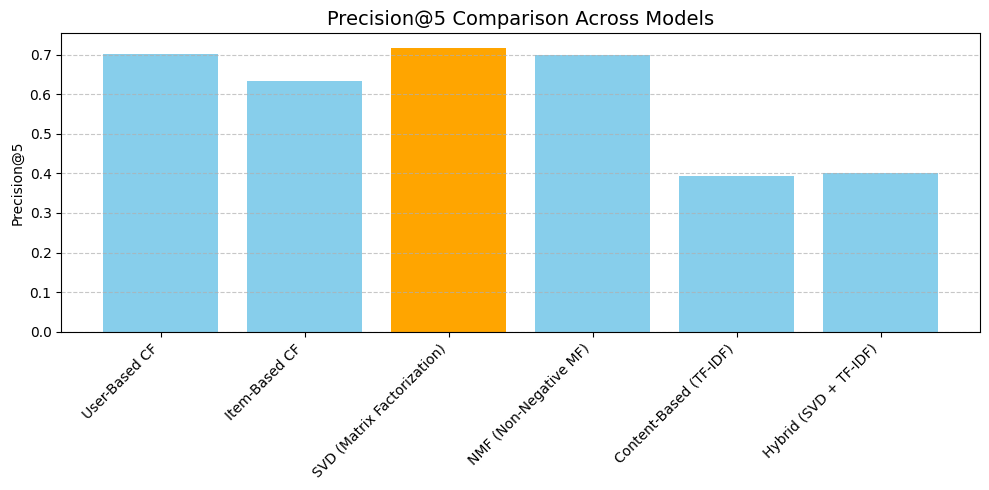

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
# Data
results = {
    "Model": [
        "User-Based CF",
        "Item-Based CF",
        "SVD (Matrix Factorization)",
        "NMF (Non-Negative MF)",
        "Content-Based (TF-IDF)",
        "Hybrid (SVD + TF-IDF)"
    ],
    "RMSE": [0.9670, 0.9282, 0.8816, 1.0205, None, None],
    "MAE": [0.7742, 0.7324, 0.6925, 0.7657, None, None],
    "Precision@5": [0.7019, 0.6334, 0.7178, 0.6998, 0.3922, 0.4000]
}

df_results = pd.DataFrame(results)

# Find best performers
best_rmse = df_results["RMSE"].min(skipna=True)
best_mae = df_results["MAE"].min(skipna=True)
best_precision = df_results["Precision@5"].max(skipna=True)

# Highlight best one
def highlight_best(val, best, reverse=False):
    if pd.isna(val):
        return ''
    if (not reverse and val == best) or (reverse and val == best):
        return 'font-weight: bold; color: green;'
    return ''

styled_df = df_results.style.applymap(lambda v: highlight_best(v, best_rmse) if v == best_rmse else '',
                                      subset=['RMSE']) \
                            .applymap(lambda v: highlight_best(v, best_mae) if v == best_mae else '',
                                      subset=['MAE']) \
                            .applymap(lambda v: highlight_best(v, best_precision) if v == best_precision else '',
                                      subset=['Precision@5'])

display(styled_df)

# Visualization
plt.figure(figsize=(10,5))
colors = ['orange' if x == best_precision else 'skyblue' for x in df_results["Precision@5"]]
plt.bar(df_results["Model"], df_results["Precision@5"], color=colors)
plt.title("Precision@5 Comparison Across Models", fontsize=14)
plt.ylabel("Precision@5")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Summary of model performance
Among all the models tested, SVD  achieved the best overall performance with the lowest RMSE (0.8816), lowest MAE (0.6925), and the highest Precision@5 (0.7178), indicating it provides the most accurate and relevant recommendations.
The User-Based CF and NMF models performed well,
The Item-Based CF model showed balanced but moderate accuracy.
While Content-Based and Hybrid approaches were included primarily for diversity .

Overall, SVD stands out as the best-performing recommendation algorithm.

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from surprise import Reader, Dataset
from functools import lru_cache
from surprise.model_selection import train_test_split

In [2]:
pip install gradio

Note: you may need to restart the kernel to use updated packages.
